# Transformers and Estimators

A ML Pipeline is  an ordered list of transformers and estimators

## The Transformer
<div>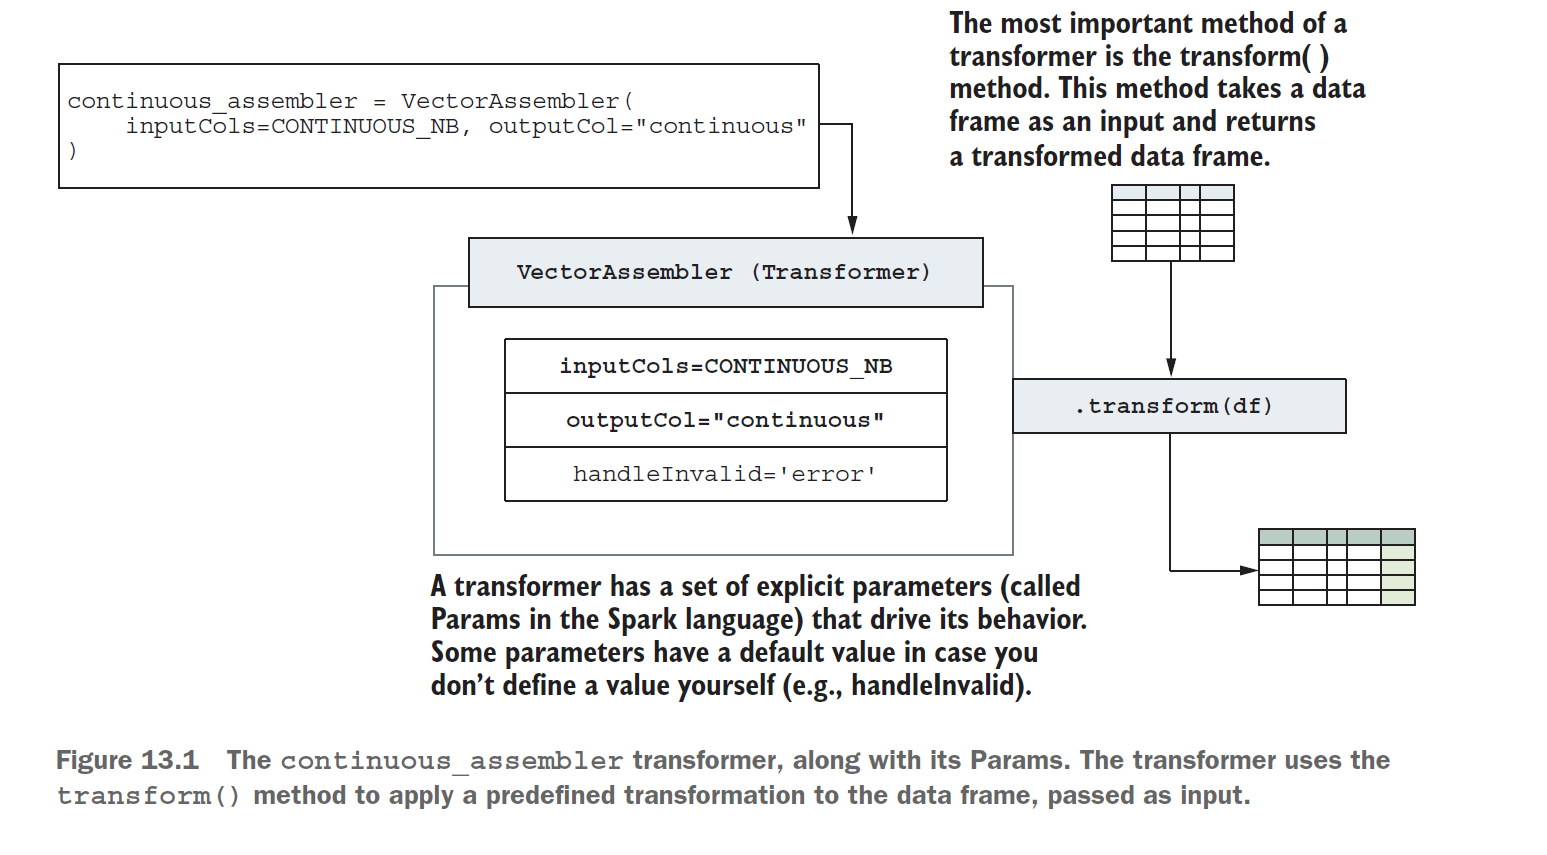</div>


In [ ]:
# Acessing a transformer's param parameters to yield a Param
print(continuous_assembler.outputCol)
# VectorAssembler_e18a6589d2d5__outputCol

In [ ]:
# Accessing the value of the outputCol Param through getOutputCol()
print(continuous_assembler.getOutputCol())

In [ ]:
print(continuous_assembler.explainParam("outputCol")) ## all params: explainParams()
# outputCol: output column name.
# (default: VectorAssembler_e18a6589d2d5__output, current: continuous)

In [ ]:
# settitng params.

continuous_assembler.setOutputCol("more_continuous")
print(continuous_assembler.getOutputCol()) # => more_continuous

In [17]:
continuous_assembler.setParams(
inputCols=["one", "two", "three"], handleInvalid="skip"
)
print(continuous_assembler.explainParams())
# handleInvalid: How to handle invalid data (NULL and NaN values). [...]
# (default: error, current: skip)
# inputCols: input column names. (current: ['one', 'two', 'three'])
# outputCol: output column name.
# (default: VectorAssembler_e18a6589d2d5__output, current: continuous)

handleInvalid: How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip'). (default: error, current: skip)
inputCols: input column names. (current: ['one', 'two', 'three'])
outputCol: output column name. (default: VectorAssembler_51005b07e612__output, current: continuous)


In [16]:
# Getting Param to default value

continuous_assembler.clear(continuous_assembler.handleInvalid)
print(continuous_assembler.getHandleInvalid()) # => error

error


# Building a ML pipeline

In [2]:
from typing import Optional

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Imputer, MinMaxScaler, VectorAssembler
from pyspark.sql import SparkSession

path = "/".join("\\sparkdata\\DataAnalysisWithPythonAndPySpark-Data\\recipes".split("\\"))



spark = (
    SparkSession.builder.appName("Recipes ML model - Are you a dessert?")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

food = spark.read.csv(
    path+"/epi_r.csv", inferSchema=True, header=True
)


def sanitize_column_name(name):
    """Drops unwanted characters from the column name.

    We replace spaces, dashes and slashes with underscore,
    and only keep alphanumeric characters."""
    answer = name
    for i, j in ((" ", "_"), ("-", "_"), ("/", "_"), ("&", "and")):
        answer = answer.replace(i, j)
    return "".join(
        [
            char
            for char in answer
            if char.isalpha() or char.isdigit() or char == "_"
        ]
    )


food = food.toDF(*[sanitize_column_name(name) for name in food.columns])


# Keeping only the relevant values for `cakeweek` and `wasteless`.
# Check the exercises for a more robust approach to this.
food = food.where(
    (F.col("cakeweek").isin([0.0, 1.0]) | F.col("cakeweek").isNull())
    & (F.col("wasteless").isin([0.0, 1.0]) | F.col("wasteless").isNull())
)

IDENTIFIERS = ["title"]

CONTINUOUS_COLUMNS = [
    "rating",
    "calories",
    "protein",
    "fat",
    "sodium",
]

TARGET_COLUMN = ["dessert"]

BINARY_COLUMNS = [
    x
    for x in food.columns
    if x not in CONTINUOUS_COLUMNS
    and x not in TARGET_COLUMN
    and x not in IDENTIFIERS
]

food = food.dropna(
    how="all",
    subset=[x for x in food.columns if x not in IDENTIFIERS],
)

food = food.dropna(subset=TARGET_COLUMN)

@F.udf(T.BooleanType())
def is_a_number(value: Optional[str]) -> bool:
    if not value:
        return True
    try:
        _ = float(value)
    except ValueError:
        return False
    return True


for column in ["rating", "calories"]:
    food = food.where(is_a_number(F.col(column)))
    food = food.withColumn(column, F.col(column).cast(T.DoubleType()))

# TODO: REMOVE THIS
maximum = {
    "calories": 3203.0,
    "protein": 173.0,
    "fat": 207.0,
    "sodium": 5661.0,
}


inst_sum_of_binary_columns = [
    F.sum(F.col(x)).alias(x) for x in BINARY_COLUMNS
]

sum_of_binary_columns = (
    food.select(*inst_sum_of_binary_columns).head().asDict()
)

num_rows = food.count()
too_rare_features = [
    k
    for k, v in sum_of_binary_columns.items()
    if v < 10 or v > (num_rows - 10)
]

BINARY_COLUMNS = list(set(BINARY_COLUMNS) - set(too_rare_features))

food = food.withColumn(
    "protein_ratio", F.col("protein") * 4 / F.col("calories")
).withColumn("fat_ratio", F.col("fat") * 9 / F.col("calories"))

CONTINUOUS_COLUMNS += ["protein_ratio", "fat_ratio"]


from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features", labelCol="dessert", predictionCol="prediction"
)



In [22]:
from pyspark.ml import Pipeline
import pyspark.ml.feature as MF

imputer = MF.Imputer(
    strategy="mean",
    inputCols=["calories", "protein", "fat", "sodium"],
    outputCols=["calories_i", "protein_i", "fat_i", "sodium_i"],
)

continuous_assembler = MF.VectorAssembler(
    inputCols=["rating", "calories_i", "protein_i", "fat_i", "sodium_i"],
    outputCol="continuous"
)

continuous_scaler = MF.MinMaxScaler(
    inputCol="continuous",
    outputCol="continuous_scaled",
)

food_pipeline = Pipeline(
    stages=[imputer, continuous_assembler, continuous_scaler]
)

Note: the pipeline is also an estimator: you fit the data, generating a _PipelineModel_

## Assembling the data set with a vector column type
PySpark requires all the data fed into a ML  estimator, to be in a single vector column

In [ ]:
food = food.dropna(how="any",subset=BINARY_COLUMNS)


In [31]:
preml_assembler = MF.VectorAssembler(
    inputCols=BINARY_COLUMNS
    + ["continuous_scaled"]
    + ["protein_ratio", "fat_ratio"],
    outputCol="features",
)

food_pipeline.setStages(
    [imputer, continuous_assembler, continuous_scaler, preml_assembler]
)

food_pipeline_model = food_pipeline.fit(food)
food_features = food_pipeline_model.transform(food)

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 43986)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.

Py4JError: An error occurred while calling o3109.fit

In [32]:
# Memory error

## Training a ML model

In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features", labelCol="dessert", predictionCol="prediction"
)

food_pipeline.setStages(
    [
    imputer,
    continuous_assembler,
    continuous_scaler,
    preml_assembler,
    lr,
    ]
)

In [ ]:
train, test = food.randomSplit([0.7, 0.3], 13)

train.cache() ## ML training will use it a lot, so keep it in cache

food_pipeline_model = food_pipeline.fit(train)
results = food_pipeline_model.transform(test)

# Evaluating and optimizing our model

## Assessing model accuracy: confusion matrix and evaluator object

### Confusion matrix

In [ ]:
results.groupby("dessert").pivot("prediction").count().show()

In [ ]:
lr_model = food_pipeline_model.stages[-1]
metrics = lr_model.evaluate(results.select("title", "dessert", "features"))
# LogisticRegressionTrainingSummary

print(f"Model precision: {metrics.precisionByLabel[1]}")
print(f"Model recall: {metrics.recallByLabel[1]}")

# Model precision: 0.9288354898336414
# Model recall: 0.9062218214607755